<div style="text-align: center; margin: 50px">

<h1 style="color: darkblue; text-align: center;">Qubit by Qubit - Semester 2</h1>
<h3>Quantum Teleporation HW 18</h3>
</div>

#### Quantum Mechanics allows to do some super cool things, one of those is quantum teleportation.!

First let's clarify what is being teleported - we are transfering a quantum state rather than an object of some sort. We can transfer $|\Psi \rangle$ from Alice to Bob without copying (cloning) the state $|\Psi \rangle$ and only sending two classical bits of information.

In this homework we are going to work through the steps of creating a teleportation circuit that will send a state $|\Psi\rangle$ from Alice to Bob but also allow us to see the states of each of the qubits thanks to the wonders of simulation.

In order to do create the circuit in a way that allows us to visualise teleportation across the qubits we need to use some fairly niche parts of qiskit. To save you from going through the depths of source code and/or documentation we have **largely completed this notebook for you**! It's your job to complete only a few functions and run everything, don't worry too much about any unusual syntax!

Try instead to really understand what is going on at each point, feel free to add you own cells and test things out.

In [1]:
# As usual import qiskit as q
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt

## Activity 1: Quantum teleportation pre-requisites

A register is just a collection of bits, they can either be quantum or classical as shown below. They make the creation of quantum circuits easier. Let's learn how to make them! For this excercise we need to create two seperate single bit classical registers (this is non-standard qiskit but makes for a great demonstration)

1. Let's create a quantum register named qr with 3 qubits and give it a **label 'q'**

`qr = q.QuantumRegister(3,'q')`

2. Let's create two classical registers, one named "c_0" and another named "c_1" each with 1 classical bit

`c_0 = q.ClassicalRegister(1, 'c0')`

`c_1 = q.ClassicalRegister(1, 'c1')`

3. We can create a quantum circuit named qc, with a quantum register named qr with 3 qubits and a classical register named cr with 2 classical bits.

`qc = q.QuantumCircuit(qr, cr_0, cr_1)`

### 1a) Create a quantum circuit using the method described as above:
Apply measurement gates on the $q_0$ to $c_0$ and the $q_1$ to $c_1$:

`qc.measure([0,1],[0,1])`

**N.B.** This should look like an empty circuit with only measurement gates

In [18]:
# TODO
qr = QuantumRegister(3,name = 'q')
cr0 = ClassicalRegister(1,name = 'c0')
cr1 = ClassicalRegister(1,name = 'c1')
Q = QuantumCircuit(qr,cr0,cr1,name = 'circuit_1')

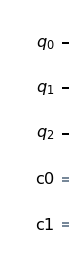

In [19]:
Q.draw('mpl')

## Conditional gates
For us to correctly create the circuit we need to use a qiskit feature where we apply a controlled gate that depends on the state of a classical bit as the control:

> `QuantumCircuit.z(2).c_if(cr_0, 1)`

This means we apply a Z gate to qubit 2 only if classical bit 0 is equal to 1

### 1b) On the circuit created above, place a conditional z gate on the $Q_2$ qubit, set the control to be classical $C_1$ on the condition that $C_1 = 1$.

In [20]:
# TODO
Q.z(2).c_if(cr0,1)

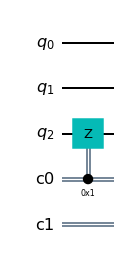

In [21]:
Q.draw('mpl')

- Nice!

# Activity 2: State teleportation!

In this experiment we are going to imagine we have two people, Alice and Bob. Alice has a state $|\Psi \rangle$ that she wants to send to Bob. Alice has qubit $Q_0$ and Bob has qubit $Q_2$, using teleportation we can show the state $|\Psi \rangle$ transfering from qubit $Q_0$ to qubit $Q_2$ on the same circuit. Unlike a swap operation, $Q_2$ and $Q_0$ never have a quantum gate connecting them - the only information transfered are two classical bits through the $C_0$ and $C_1$ registers.

In order to teleport the state $|\Psi \rangle$, we must create an entagled pair of qubits and give one of them to Alice and the other to Bob. In the experiement we can imagine a third person Charlie creating the entangled pair to each of Alice and Bob, this is going to be qubit $Q_1$ and $Q_2$.

Confused? Let me clarify:

Alice starts with $Q_0$,
Charlie creates and entagled pair: $Q_1$ and $Q_2$
Charlie then distritbutes $Q_1$ to Alice and $Q_2$ to Bob

At this point our teleportation circuit if prepared!

In order for Alice to send the state $|\Psi \rangle$ of $Q_0$, she only needs to send two classical bits of data to Bob and Bob will be able to completely recreate the state $|\Psi \rangle$ on his $Q_2$!

Amazing! But there's two more key parts we need to figure out: Alice needs to know what two classical bits to send to Bob, and Bob needs to know how to interpret those classical bit's as intructions to recreate $|\Psi \rangle$.

### Let's first define a function that creates our abstracted teleportation protocol, we've done this for you:

**N.B.** When reading through this function you may notice a unusual gate being applied called `qc.snapshot("1")` this gate allows us to save the current value of the statevector at any stage of the circuit. It is only allowed to be used when simulating on the `statevector_simulator`, this is because the `statevector_simulator` is simulating the experiment by calculating probabilities at each point of the circuit. As it is a simulation and does not involve any real qubits, recording (and therefore measuring) does not alter the state of the qubits.

In [98]:
def my_teleport(psi):
    # make a random state 
    init_state = extensions.Initialize(psi)
    init_state.label = "random_state"
    print("Initialized state is :",init_state)
    # creating the circuit 
    c1 = ClassicalRegister(1, name='cr0')
    c2 = ClassicalRegister(1, name='cr1')
    q = QuantumRegister(3,name = 'q')
    Q = QuantumCircuit(q,c1,c2)
    # 1. create a shared entangled pair 
    Q.h(1)
    Q.cx(1,2)
    
    #2. now initialize the unknown qubit with init_state
    Q.append(init_state,[0])
    display(Q.draw('mpl'))
    Q.barrier()
    
    #3. now entangle the alice qubit and the initialized qubit 
    Q.cx(0,1)
    Q.h(0)
    display(Q.draw('mpl'))
    Q.barrier()
    
    #4. now perform the measurements
    ## 00 - no change 
    ## 01 - unknown - 0, alice - 1, then X gate on Q2 
    ## 10 - unknown - 1, alice - 0, then Z gate on Q2 
    ## 11 - both 1, then first X, then Z on Q2 
    Q.measure([0,1],[0,1])
    
    Q.x(2).c_if(c2,1) # because alice par hai X
    Q.z(2).c_if(c1,1) # unknown par hai Z 
    display(Q.draw('mpl'))
    
    Q.snapshot('2')
    return Q
    ## now you just need to see whether your state was transferred or not 

In [66]:
psi = quantum_info.random_state(2)
psi_ = np.conj(psi)
np.dot(psi_,psi)

E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  """Entry point for launching an IPython kernel.


(1+0j)

In [99]:
print("Psi was :",psi)

Psi was : [ 0.83061213+0.11674449j -0.22082621+0.49768464j]


Initialized state is : <qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x00000290A594BB88>


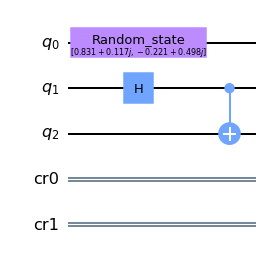

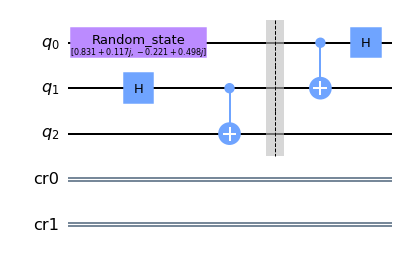

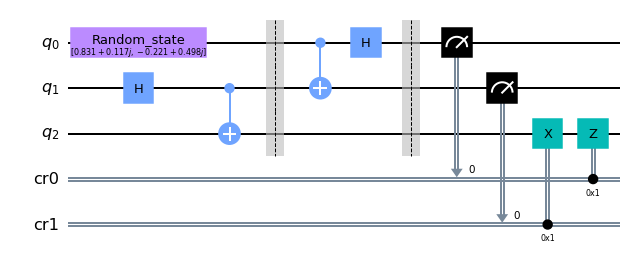

In [100]:
q = my_teleport(psi)

## Note
- The indexing is very important here
- See Bob's qubit as the **most significant qubit and unknown state as  the least significant qubit to correctly apply the decoding and measurements circuit!**

In [110]:
backend = Aer.get_backend('statevector_simulator')
result = execute(circ, backend).result()

# Put our snapshots into a list
snapshots = result.data()['snapshots']['statevector']
bob_state = snapshots['2']
state = [np.round(i,8) for i in bob_state[0] if i!=0]
print(state)
print("Original state : ",psi)
print("Yes ! we were successful!")

[(0.83061213+0.11674449j), (-0.22082621+0.49768464j)]
Original state :  [ 0.83061213+0.11674449j -0.22082621+0.49768464j]
Yes ! we were successful!


In [92]:
# Teleportation Protocol:

def teleportation_circuit(psi):

    # First we make our state Psi into a initialisation gate
    init_gate = extensions.Initialize(psi)
    init_gate.label = "Secret Message!"
    
    # Create our circuit!
    qr = QuantumRegister(3, name="q")   # Create a 3 qubit quantum register
    c_0 = ClassicalRegister(1, name="c_0") # Create 2 single bit classical registers
    c_1 = ClassicalRegister(1, name="c_1")
    qc = QuantumCircuit(qr, c_0, c_1)

    # Initialise Alice's Qubit to have state Psi
    qc.append(init_gate, [0])
    # We use barrier to split up each segment
    qc.barrier()
    
    # Use snapshot magic to record the initial statevector
    qc.snapshot('1')
    # We use barrier to split up each segment
    qc.barrier()

    # Charlie creates the Bell pair
    create_bell_pair(qc, 1, 2)
    # We use barrier to split up each segment
    qc.barrier()

    # Alice does gate prep
    alice_gates(qc, 0, 1)
    # We use barrier to split up each segment
    qc.barrier()

    # Alice measures her state and sends to Bob
    measure_and_send(qc, 0, 1)
    # We use barrier to split up each segment
    qc.barrier()

    # Bob decodes the classical bits and re-creates Psi
    bob_gates(qc, 2, c_0, c_1)
    # We use barrier to split up each segment
    qc.barrier()
    
    # Use snapshot magic to record the final statevector
    qc.snapshot('2')  
    display(qc.draw('mpl'))
    # We want our function to return a fully prepared circuit
    return qc

# Alice, Bob, and Charlie steps:


Charlie needs to make an entangled pair - we are going to create the $|\Phi^+\rangle$ state between the $q_1$ and $q_2$ qubits, where:

$$
| \Phi^+ \rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle
$$

Alice is now going to apply a CNOT gate with $Q_0$ as control and $Q_1$ as target as well as a hadamard to $Q_0$.

Then Alice will measure the $Q_0$ and $Q_1$ qubits and send the classical values to Bob via the classical register.

Now with only two bits of classical information, Bob can completely recreate the state of $| \Psi \rangle$ on his end!

To do this he can follow the following format:

**If the first bit is 1, he applies a Z gate, if the second bit is 1 he applies an X gate.**

00 = Nothing

01 = $X$ gate

10 = $Z$ gate

11 = $ZX$ gate

## 2a) Complete the `create_bell_pair()` and `alice_gate()` functions:
Use the `measure_and_send()` and `bob_gates()` as templates!

In [22]:
def create_bell_pair(qc, a, b):
    # Here we want to create the Phi+ bell state
    # 1. Place a hadamard gate on 'a'
    # 2. Place a CNOT gate with 'a' as control and 'b' as target
    qc.h(a)
    qc.cx(a,b)
    
    # TODO

In [25]:
def alice_gates(qc, a, b):
    # 1. Place a CNOT gate with 'a' as control and 'b' as target
    # 2. Place a hadamard gate on 'a'
    qc.cx(a,b)
    qc.h(a)
    # TODO

In [24]:
def measure_and_send(qc, a, b):
    # Measure a to 0 and b to 1
    qc.measure(a,0)
    qc.measure(b,1)

In [46]:
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1

# Activity 3: Simulating Quantum Teleportation!

Let's run a simulation on the `statevector_simulator`. We've created Alice's $| \Psi \rangle$ state for you:

In [42]:
psi = np.array([0.5533920757991503+0.3043529040180291j, 0.6147796854942953+0.4724113234904887j])

Now we can create a teleporter circuit using the teleportation_circuit function we defined above:

`circ = teleportation_circuit(psi)`

### 3a) Create a `teleportation_circuit()` object called `circ` and draw it:

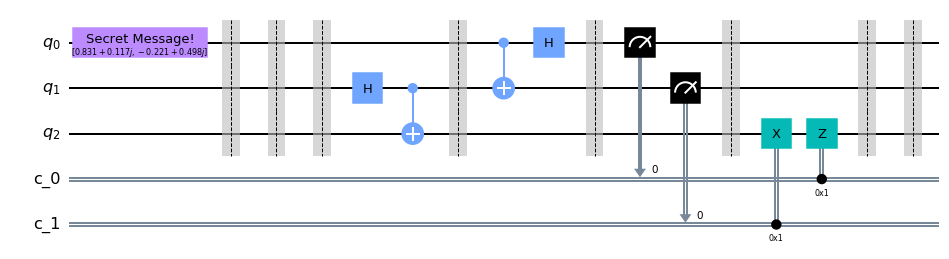

In [93]:
# Make a teleportation circuit called circ here: 
circ = teleportation_circuit(psi)
# TODO

### Test out your new teleportation circuit!

First we can simulate it using the statvector_simulator:

In [94]:
# Execute the circuit on the simulated backend
backend = Aer.get_backend('statevector_simulator')
result = execute(circ, backend).result()

# Put our snapshots into a list
snapshots = result.data()['snapshots']['statevector']

# Get Alice's state:
alice_state = snapshots['1']

# Get Bob's final state:
bob_state = snapshots['2']

### Next we can use this cell to check if we've implemented the circuit correctly!

Running this cell will print out Alice and Bob's states from the start and finish of the experiment!

#### Further work: Try changing Psi and see if it still works! How would you expand this circuit to send more than one state to Bob?

In [95]:
def check_same_state(alice, bob, psi):
    a = alice[0]
    b = [c for c in bob[0] if c != 0]
    print("Psi state: ", psi[0], psi[1])
    print("Alice's state: ", a[0], a[1])
    print("Bob's state: ", b[0], b[1])
    # For simplicity I am rounding and summing to check for equality
    if np.round(a[0]+a[1], 5) == np.round(b[0]+ b[1], 5):
        print("State Successfully Teleported!")
    else:
        print("Error: Bob did not get the right state!")

# Check if it's the same state
check_same_state(alice_state, bob_state, psi)

Psi state:  (0.8306121313505724+0.11674448848219421j) (-0.2208262109777345+0.4976846352937844j)
Alice's state:  (0.8306121313505724+0.11674448848219421j) (-0.2208262109777345+0.4976846352937844j)
Bob's state:  (0.8306121313505723+0.11674448848219421j) (-0.22082621097773447+0.4976846352937845j)
State Successfully Teleported!


### © 2020 The Coding School

**All rights reserved**

*Use of this activity is for personal use only. Copying, reproducing, distributing, posting or sharing this activity in any manner with any third party are prohibited under the terms of this registration. All rights not specifically licensed under the registration are reserved.*